# Method 3 - Best Ideas High Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

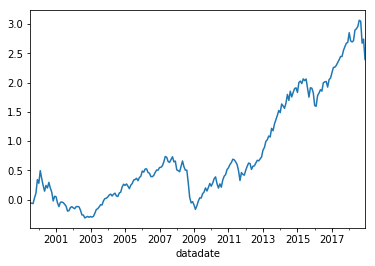

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.342619
2000-12-31   -0.210932
2001-12-31   -0.169241
2002-12-31   -0.205730
2003-12-31    0.464767
2004-12-31    0.234468
2005-12-31    0.107577
2006-12-31    0.074610
2007-12-31    0.102902
2008-12-31   -0.417405
2009-12-31    0.320949
2010-12-31    0.187277
2011-12-31   -0.064188
2012-12-31    0.218708
2013-12-31    0.459547
2014-12-31    0.153277
2015-12-31   -0.028478
2016-12-31    0.088255
2017-12-31    0.198206
2018-12-31   -0.079371
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     441.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.23e-106
Time:                        13:02:11   Log-Likelihood:                 618.70
No. Observations:                 234   AIC:                            -1227.
Df Residuals:                     229   BIC:                            -1210.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.896      0.371      -0.001       0.003
mktrf          0.9704      0.032     29.929      0.000       0.907       1.034
me             0.4419      0.038     11.717      0.000       0.368       0.516
ia            -0.3095      0.057     -5.400      0.000      -0.422      -0.197
roe            0.1351      0.049      2.754      0.006       0.038       0.232
==============================================================================
Omnibus:                       62.792   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              766.015
Skew:                           0.612   Prob(JB):                    4.59e-167
Kurtosis:                      11.779   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     230.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.42e-79
Time:                        13:02:11   Log-Likelihood:                 618.70
No. Observations:                 234   AIC:                            -1227.
Df Residuals:                     229   BIC:                            -1210.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.837      0.403      -0.001       0.004
mktrf          0.9704      0.046     21.155      0.000       0.880       1.060
me             0.4419      0.075      5.904      0.000       0.295       0.589
ia            -0.3095      0.118     -2.634      0.008      -0.540      -0.079
roe            0.1351      0.070      1.927      0.054      -0.002       0.273
==============================================================================
Omnibus:                       62.792   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              766.015
Skew:                           0.612   Prob(JB):                    4.59e-167
Kurtosis:                      11.779   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     281.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.15e-87
Time:                        13:02:11   Log-Likelihood:                 618.70
No. Observations:                 234   AIC:                            -1227.
Df Residuals:                     229   BIC:                            -1210.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.819      0.413      -0.001       0.004
mktrf          0.9704      0.036     27.175      0.000       0.900       1.040
me             0.4419      0.075      5.895      0.000       0.295       0.589
ia            -0.3095      0.112     -2.753      0.006      -0.530      -0.089
roe            0.1351      0.066      2.049      0.040       0.006       0.264
==============================================================================
Omnibus:                       62.792   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              766.015
Skew:                           0.612   Prob(JB):                    4.59e-167
Kurtosis:                      11.779   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     314.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.28e-100
Time:                        13:02:11   Log-Likelihood:                 607.02
No. Observations:                 234   AIC:                            -1202.
Df Residuals:                     228   BIC:                            -1181.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.597      0.112      -0.000       0.005
mktrf          0.9274      0.034     27.096      0.000       0.860       0.995
smb            0.4021      0.045      8.905      0.000       0.313       0.491
hml           -0.1644      0.053     -3.088      0.002      -0.269      -0.059
rmw           -0.0691      0.060     -1.147      0.252      -0.188       0.050
cma           -0.0148      0.077     -0.194      0.846      -0.166       0.136
==============================================================================
Omnibus:                       44.219   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.513
Skew:                           0.318   Prob(JB):                     2.39e-88
Kurtosis:                       9.402   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     422.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.61e-113
Time:                        13:02:11   Log-Likelihood:                 607.02
No. Observations:                 234   AIC:                            -1202.
Df Residuals:                     228   BIC:                            -1181.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.456      0.145      -0.001       0.005
mktrf          0.9274      0.048     19.312      0.000       0.833       1.021
smb            0.4021      0.074      5.469      0.000       0.258       0.546
hml           -0.1644      0.077     -2.128      0.033      -0.316      -0.013
rmw           -0.0691      0.100     -0.688      0.492      -0.266       0.128
cma           -0.0148      0.176     -0.085      0.933      -0.359       0.329
==============================================================================
Omnibus:                       44.219   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.513
Skew:                           0.318   Prob(JB):                     2.39e-88
Kurtosis:                       9.402   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     640.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.43e-132
Time:                        13:02:11   Log-Likelihood:                 607.02
No. Observations:                 234   AIC:                            -1202.
Df Residuals:                     228   BIC:                            -1181.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.438      0.150      -0.001       0.005
mktrf          0.9274      0.046     20.378      0.000       0.838       1.017
smb            0.4021      0.065      6.201      0.000       0.275       0.529
hml           -0.1644      0.079     -2.078      0.038      -0.320      -0.009
rmw           -0.0691      0.107     -0.646      0.518      -0.279       0.140
cma           -0.0148      0.183     -0.081      0.935      -0.374       0.345
==============================================================================
Omnibus:                       44.219   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.513
Skew:                           0.318   Prob(JB):                     2.39e-88
Kurtosis:                       9.402   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     539.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.71e-115
Time:                        13:02:11   Log-Likelihood:                 639.70
No. Observations:                 234   AIC:                            -1269.
Df Residuals:                     229   BIC:                            -1252.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.412      0.680      -0.002       0.003
mktrf          1.0480      0.027     38.401      0.000       0.994       1.102
smb            0.3390      0.034      9.952      0.000       0.272       0.406
hml           -0.0662      0.034     -1.958      0.052      -0.133       0.000
umd            0.1943      0.022      8.751      0.000       0.151       0.238
==============================================================================
Omnibus:                       28.842   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.690
Skew:                           0.152   Prob(JB):                     1.56e-34
Kurtosis:                       6.984   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     448.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.67e-107
Time:                        13:02:11   Log-Likelihood:                 639.70
No. Observations:                 234   AIC:                            -1269.
Df Residuals:                     229   BIC:                            -1252.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.439      0.661      -0.002       0.002
mktrf          1.0480      0.045     23.462      0.000       0.960       1.136
smb            0.3390      0.050      6.761      0.000       0.241       0.437
hml           -0.0662      0.043     -1.533      0.125      -0.151       0.018
umd            0.1943      0.044      4.443      0.000       0.109       0.280
==============================================================================
Omnibus:                       28.842   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.690
Skew:                           0.152   Prob(JB):                     1.56e-34
Kurtosis:                       6.984   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     529.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.09e-114
Time:                        13:02:11   Log-Likelihood:                 639.70
No. Observations:                 234   AIC:                            -1269.
Df Residuals:                     229   BIC:                            -1252.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.432      0.666      -0.002       0.002
mktrf          1.0480      0.041     25.321      0.000       0.967       1.129
smb            0.3390      0.039      8.649      0.000       0.262       0.416
hml           -0.0662      0.040     -1.656      0.098      -0.145       0.012
umd            0.1943      0.046      4.181      0.000       0.103       0.285
==============================================================================
Omnibus:                       28.842   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.690
Skew:                           0.152   Prob(JB):                     1.56e-34
Kurtosis:                       6.984   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     178.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.42e-48
Time:                        13:02:11   Log-Likelihood:                 288.65
No. Observations:                 120   AIC:                            -567.3
Df Residuals:                     115   BIC:                            -553.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.142      0.887      -0.004       0.005
mktrf          1.0117      0.057     17.600      0.000       0.898       1.126
me             0.5038      0.057      8.873      0.000       0.391       0.616
ia            -0.3728      0.089     -4.193      0.000      -0.549      -0.197
roe            0.2442      0.079      3.103      0.002       0.088       0.400
==============================================================================
Omnibus:                       27.643   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.556
Skew:                           0.569   Prob(JB):                     3.67e-30
Kurtosis:                       8.081   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     115.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.48e-39
Time:                        13:02:12   Log-Likelihood:                 288.65
No. Observations:                 120   AIC:                            -567.3
Df Residuals:                     115   BIC:                            -553.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.142      0.887      -0.004       0.004
mktrf          1.0117      0.077     13.164      0.000       0.861       1.162
me             0.5038      0.086      5.854      0.000       0.335       0.672
ia            -0.3728      0.145     -2.569      0.010      -0.657      -0.088
roe            0.2442      0.089      2.743      0.006       0.070       0.419
==============================================================================
Omnibus:                       27.643   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.556
Skew:                           0.569   Prob(JB):                     3.67e-30
Kurtosis:                       8.081   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     156.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-45
Time:                        13:02:12   Log-Likelihood:                 288.65
No. Observations:                 120   AIC:                            -567.3
Df Residuals:                     115   BIC:                            -553.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.146      0.884      -0.004       0.004
mktrf          1.0117      0.058     17.323      0.000       0.897       1.126
me             0.5038      0.088      5.749      0.000       0.332       0.676
ia            -0.3728      0.142     -2.633      0.008      -0.650      -0.095
roe            0.2442      0.067      3.633      0.000       0.112       0.376
==============================================================================
Omnibus:                       27.643   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.556
Skew:                           0.569   Prob(JB):                     3.67e-30
Kurtosis:                       8.081   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     117.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.26e-43
Time:                        13:02:12   Log-Likelihood:                 279.36
No. Observations:                 120   AIC:                            -546.7
Df Residuals:                     114   BIC:                            -530.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.059      0.292      -0.002       0.007
mktrf          0.9346      0.066     14.207      0.000       0.804       1.065
smb            0.4500      0.075      6.040      0.000       0.302       0.598
hml           -0.2037      0.091     -2.231      0.028      -0.385      -0.023
rmw           -0.0129      0.108     -0.119      0.905      -0.226       0.200
cma           -0.0012      0.118     -0.010      0.992      -0.235       0.232
==============================================================================
Omnibus:                       15.095   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               50.583
Skew:                           0.204   Prob(JB):                     1.04e-11
Kurtosis:                       6.154   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     159.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-49
Time:                        13:02:12   Log-Likelihood:                 279.36
No. Observations:                 120   AIC:                            -546.7
Df Residuals:                     114   BIC:                            -530.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.047      0.295      -0.002       0.007
mktrf          0.9346      0.090     10.358      0.000       0.758       1.111
smb            0.4500      0.101      4.456      0.000       0.252       0.648
hml           -0.2037      0.110     -1.853      0.064      -0.419       0.012
rmw           -0.0129      0.139     -0.093      0.926      -0.285       0.259
cma           -0.0012      0.229     -0.005      0.996      -0.450       0.447
==============================================================================
Omnibus:                       15.095   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               50.583
Skew:                           0.204   Prob(JB):                     1.04e-11
Kurtosis:                       6.154   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     214.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.11e-56
Time:                        13:02:12   Log-Likelihood:                 279.36
No. Observations:                 120   AIC:                            -546.7
Df Residuals:                     114   BIC:                            -530.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.037      0.300      -0.002       0.007
mktrf          0.9346      0.086     10.829      0.000       0.765       1.104
smb            0.4500      0.088      5.107      0.000       0.277       0.623
hml           -0.2037      0.114     -1.781      0.075      -0.428       0.021
rmw           -0.0129      0.147     -0.087      0.930      -0.301       0.276
cma           -0.0012      0.236     -0.005      0.996      -0.464       0.461
==============================================================================
Omnibus:                       15.095   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               50.583
Skew:                           0.204   Prob(JB):                     1.04e-11
Kurtosis:                       6.154   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     240.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.05e-55
Time:                        13:02:12   Log-Likelihood:                 304.39
No. Observations:                 120   AIC:                            -598.8
Df Residuals:                     115   BIC:                            -584.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.953      0.342      -0.002       0.005
mktrf          1.1117      0.044     25.030      0.000       1.024       1.200
smb            0.3175      0.051      6.278      0.000       0.217       0.418
hml           -0.0728      0.051     -1.436      0.154      -0.173       0.028
umd            0.2446      0.031      7.833      0.000       0.183       0.306
==============================================================================
Omnibus:                       11.578   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               28.271
Skew:                          -0.211   Prob(JB):                     7.26e-07
Kurtosis:                       5.340   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     404.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-66
Time:                        13:02:12   Log-Likelihood:                 304.39
No. Observations:                 120   AIC:                            -598.8
Df Residuals:                     115   BIC:                            -584.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.176      0.240      -0.001       0.005
mktrf          1.1117      0.064     17.264      0.000       0.986       1.238
smb            0.3175      0.061      5.164      0.000       0.197       0.438
hml           -0.0728      0.049     -1.480      0.139      -0.169       0.024
umd            0.2446      0.050      4.851      0.000       0.146       0.343
==============================================================================
Omnibus:                       11.578   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               28.271
Skew:                          -0.211   Prob(JB):                     7.26e-07
Kurtosis:                       5.340   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     554.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.81e-74
Time:                        13:02:12   Log-Likelihood:                 304.39
No. Observations:                 120   AIC:                            -598.8
Df Residuals:                     115   BIC:                            -584.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.229      0.219      -0.001       0.005
mktrf          1.1117      0.049     22.582      0.000       1.015       1.208
smb            0.3175      0.046      6.915      0.000       0.227       0.407
hml           -0.0728      0.042     -1.746      0.081      -0.154       0.009
umd            0.2446      0.044      5.503      0.000       0.158       0.332
==============================================================================
Omnibus:                       11.578   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               28.271
Skew:                          -0.211   Prob(JB):                     7.26e-07
Kurtosis:                       5.340   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     605.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.97e-73
Time:                        13:02:12   Log-Likelihood:                 383.37
No. Observations:                 114   AIC:                            -756.7
Df Residuals:                     109   BIC:                            -743.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.948      0.054   -2.92e-05       0.003
mktrf          0.9655      0.025     38.319      0.000       0.916       1.015
me             0.2715      0.039      6.979      0.000       0.194       0.349
ia            -0.1991      0.054     -3.689      0.000      -0.306      -0.092
roe           -0.0844      0.047     -1.781      0.078      -0.178       0.010
==============================================================================
Omnibus:                        0.098   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.952   Jarque-Bera (JB):                0.265
Skew:                          -0.019   Prob(JB):                        0.876
Kurtosis:                       2.767   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     912.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.47e-83
Time:                        13:02:12   Log-Likelihood:                 383.37
No. Observations:                 114   AIC:                            -756.7
Df Residuals:                     109   BIC:                            -743.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.516      0.130      -0.000       0.004
mktrf          0.9655      0.019     50.855      0.000       0.928       1.003
me             0.2715      0.037      7.331      0.000       0.199       0.344
ia            -0.1991      0.065     -3.067      0.002      -0.326      -0.072
roe           -0.0844      0.052     -1.639      0.101      -0.185       0.017
==============================================================================
Omnibus:                        0.098   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.952   Jarque-Bera (JB):                0.265
Skew:                          -0.019   Prob(JB):                        0.876
Kurtosis:                       2.767   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1124.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.34e-87
Time:                        13:02:12   Log-Likelihood:                 383.37
No. Observations:                 114   AIC:                            -756.7
Df Residuals:                     109   BIC:                            -743.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.325      0.185      -0.001       0.004
mktrf          0.9655      0.017     57.341      0.000       0.933       0.999
me             0.2715      0.036      7.599      0.000       0.201       0.342
ia            -0.1991      0.065     -3.049      0.002      -0.327      -0.071
roe           -0.0844      0.046     -1.840      0.066      -0.174       0.006
==============================================================================
Omnibus:                        0.098   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.952   Jarque-Bera (JB):                0.265
Skew:                          -0.019   Prob(JB):                        0.876
Kurtosis:                       2.767   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     481.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.13e-72
Time:                        13:02:12   Log-Likelihood:                 383.61
No. Observations:                 114   AIC:                            -755.2
Df Residuals:                     108   BIC:                            -738.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.919      0.360      -0.001       0.002
mktrf          0.9665      0.024     40.117      0.000       0.919       1.014
smb            0.2681      0.039      6.856      0.000       0.191       0.346
hml           -0.1084      0.050     -2.173      0.032      -0.207      -0.010
rmw           -0.1811      0.061     -2.966      0.004      -0.302      -0.060
cma           -0.0896      0.078     -1.156      0.250      -0.243       0.064
==============================================================================
Omnibus:                        3.516   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                2.912
Skew:                          -0.319   Prob(JB):                        0.233
Kurtosis:                       3.453   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     636.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.14e-78
Time:                        13:02:12   Log-Likelihood:                 383.61
No. Observations:                 114   AIC:                            -755.2
Df Residuals:                     108   BIC:                            -738.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.752      0.452      -0.001       0.003
mktrf          0.9665      0.021     46.917      0.000       0.926       1.007
smb            0.2681      0.038      6.996      0.000       0.193       0.343
hml           -0.1084      0.037     -2.941      0.003      -0.181      -0.036
rmw           -0.1811      0.052     -3.479      0.001      -0.283      -0.079
cma           -0.0896      0.081     -1.107      0.268      -0.248       0.069
==============================================================================
Omnibus:                        3.516   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                2.912
Skew:                          -0.319   Prob(JB):                        0.233
Kurtosis:                       3.453   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     781.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.64e-83
Time:                        13:02:12   Log-Likelihood:                 383.61
No. Observations:                 114   AIC:                            -755.2
Df Residuals:                     108   BIC:                            -738.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.714      0.475      -0.001       0.003
mktrf          0.9665      0.019     50.175      0.000       0.929       1.004
smb            0.2681      0.038      7.029      0.000       0.193       0.343
hml           -0.1084      0.032     -3.347      0.001      -0.172      -0.045
rmw           -0.1811      0.060     -2.998      0.003      -0.300      -0.063
cma           -0.0896      0.076     -1.186      0.235      -0.238       0.058
==============================================================================
Omnibus:                        3.516   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                2.912
Skew:                          -0.319   Prob(JB):                        0.233
Kurtosis:                       3.453   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     550.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.87e-71
Time:                        13:02:12   Log-Likelihood:                 378.16
No. Observations:                 114   AIC:                            -746.3
Df Residuals:                     109   BIC:                            -732.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.211      0.833      -0.002       0.002
mktrf          0.9864      0.025     39.463      0.000       0.937       1.036
smb            0.3068      0.039      7.873      0.000       0.230       0.384
hml           -0.0883      0.040     -2.199      0.030      -0.168      -0.009
umd            0.0193      0.030      0.638      0.525      -0.041       0.079
==============================================================================
Omnibus:                        1.933   Durbin-Watson:                   1.445
Prob(Omnibus):                  0.380   Jarque-Bera (JB):                1.548
Skew:                          -0.279   Prob(JB):                        0.461
Kurtosis:                       3.122   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     667.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.20e-75
Time:                        13:02:12   Log-Likelihood:                 378.16
No. Observations:                 114   AIC:                            -746.3
Df Residuals:                     109   BIC:                            -732.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.168      0.867      -0.002       0.002
mktrf          0.9864      0.022     45.835      0.000       0.944       1.029
smb            0.3068      0.034      8.980      0.000       0.240       0.374
hml           -0.0883      0.033     -2.706      0.007      -0.152      -0.024
umd            0.0193      0.020      0.955      0.339      -0.020       0.059
==============================================================================
Omnibus:                        1.933   Durbin-Watson:                   1.445
Prob(Omnibus):                  0.380   Jarque-Bera (JB):                1.548
Skew:                          -0.279   Prob(JB):                        0.461
Kurtosis:                       3.122   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1038.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.29e-86
Time:                        13:02:12   Log-Likelihood:                 378.16
No. Observations:                 114   AIC:                            -746.3
Df Residuals:                     109   BIC:                            -732.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.164      0.870      -0.002       0.002
mktrf          0.9864      0.020     49.043      0.000       0.947       1.026
smb            0.3068      0.030     10.093      0.000       0.247       0.366
hml           -0.0883      0.029     -3.017      0.003      -0.146      -0.031
umd            0.0193      0.020      0.972      0.331      -0.020       0.058
==============================================================================
Omnibus:                        1.933   Durbin-Watson:                   1.445
Prob(Omnibus):                  0.380   Jarque-Bera (JB):                1.548
Skew:                          -0.279   Prob(JB):                        0.461
Kurtosis:                       3.122   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""